In [1]:
import os
import json
from collections import defaultdict

# Path to the DOTA dataset annotations folder
annotations_folder = '/data/DOTA_split/annotations/'

# Create a defaultdict to store the number of objects and object class for each image
image_info = defaultdict(lambda: defaultdict(int))

# Loop through each annotation file in the annotations folder
for filename in os.listdir(annotations_folder):
    if filename.endswith('train_fixed.json'):
        # Load the annotation file
        with open(os.path.join(annotations_folder, filename), 'r') as f:
            annotation = json.load(f)
            tmp = annotation['categories']
            catid2name = {}
            for item in tmp:
                catid2name[item['id']] = item['name']

        # Update the defaultdict with the number of objects and object class for each image in the annotation data
        for obj in annotation['annotations']:
            image_id = obj['image_id']
            class_name = catid2name[obj['category_id']]
            image_info[image_id][class_name] += 1

In [5]:
import random

classid2imcrop = defaultdict(list)
for obj in annotation['annotations']:
    if obj['area'] >= 0:
        classid2imcrop[obj['category_id']].append(obj)
        
top_sized_classid2imcrop = defaultdict(list)
for k,v in classid2imcrop.items():  
    sorted_list = sorted(v, key=lambda x: x['area'], reverse=True)
    # select top sized crops
    top_sized_classid2imcrop[k] = sorted_list[:500]
    # random select crops
    #sample_size = 500
    #top_sized_classid2imcrop[k] = [random.choice(v) for _ in range(sample_size)]



In [32]:
for i, item in enumerate(top_sized_classid2imcrop[0]):
    if item['area'] < 100:
        print (i, item)

1 {'area': 90.0, 'category_id': 0, 'iscrowd': 0, 'bbox': [64, 203, 10, 9], 'image_id': 22921, 'id': 106504}
491 {'area': 35.0, 'category_id': 0, 'iscrowd': 0, 'bbox': [85, 109, 5, 7], 'image_id': 84333, 'id': 378699}


In [7]:
imgid2fname = {anno['id']:anno['file_name'] for anno in annotation['images']}

In [8]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np

In [9]:
def crop_image(image, x, y, xsize=None, ysize=None):
    indexes = (x, y, x+xsize, y+ysize)
    cropped_image = image.crop(indexes)
    return cropped_image

In [13]:
img_root = '/data/DOTA_split/train/images/'
picked_classid2imcrop = defaultdict(list)

for k,v in top_sized_classid2imcrop.items():
  
    for vv in v:
        imgid = vv['image_id']
        bbox = vv['bbox']
        img = Image.open(img_root+imgid2fname[imgid])
        w, h = img.size
        
        crop_lx, crop_ly, crop_xsize, crop_ysize = bbox[0]-5, bbox[1]-5, bbox[2]+10, bbox[3]+10
        if crop_lx < 0:
            crop_lx = 0
        if crop_ly < 0:
            crop_ly = 0
        if crop_lx+crop_xsize > w:
            crop_xsize = w - crop_lx
        if crop_ly+crop_ysize > h:
            crop_ysize = h - crop_ly
        cropped_image = crop_image(img, crop_lx, crop_ly, crop_xsize, crop_ysize)
        picked_classid2imcrop[k].append(cropped_image)

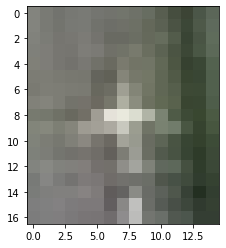

In [33]:
plt.figure()
plt.imshow(picked_classid2imcrop[0][491])

In [34]:
all_classids = top_sized_classid2imcrop.keys()
prompts = {}
save_dir = '/data/DOTA_split_500crops_per_cls_train'
for cls_id in all_classids:
    print (cls_id)
    for i, (anno, imgcrop) in enumerate(zip(top_sized_classid2imcrop[cls_id], picked_classid2imcrop[cls_id])):
        new_fname = imgid2fname[anno['image_id']].replace('.jpg', '__'+str(i)+'.jpg')
        imgcrop.save(os.path.join(save_dir, new_fname))
        prompts[new_fname] = 'birdview of ' + catid2name[anno['category_id']]
with open('crop_captions.json', 'w') as f:
    json.dump(prompts, f)


0
9
10
7
1
3
4
14
11
8
12
17
2
5
16
6
13
15
